In [13]:
#imports 
import pandas as pd
import numpy as np
import os
import pickle
import datetime as datetime
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm
import dgl.function as fn
from tqdm import tqdm

#imports for graph creation
import torch
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

#imports for graph learning
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
from tqdm import trange
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms

# Create Dataset

In [14]:
class TradeNetwork:
    """
    We define a class which computes the MST trade network for a given year 
    """
    
    def __init__(self, year = 1962, data_dir = "data"):
        self.year = year
        self.data_dir = data_dir
        
    def prepare_features(self, filter_gdp = True):
        
        ###IMPORT GDP###
        #prepare GDP as a set of features 
        self.gdp = pd.read_csv(self.data_dir + "/gdp.csv")
        scaler = StandardScaler()
        self.gdp[["prev_gdp"]] = scaler.fit_transform(np.log(self.gdp[[str(self.year-1)]]))
        self.gdp[["current_gdp"]] = scaler.fit_transform(np.log(self.gdp[[str(self.year)]]))
        #rename and keep relevant columns
        self.gdp["country_code"] = self.gdp["Country Code"]
        self.gdp = self.gdp[["country_code", "prev_gdp", "current_gdp"]].dropna()
        
        ###IMPORT GDP GROWTH###
        #prepare GDP growth
        self.gdp_growth = pd.read_csv(self.data_dir + "/gdp_growth.csv")
        self.gdp_growth["prev_gdp_growth"] = self.gdp_growth[str(self.year-1)]
        self.gdp_growth["current_gdp_growth"] = self.gdp_growth[str(self.year)] 
        self.gdp_growth["future_gdp_growth"] = self.gdp_growth[str(self.year+1)]
        #rename and keep relevant columns
        self.gdp_growth["country_code"] = self.gdp_growth["Country Code"]
        self.gdp_growth = self.gdp_growth[["country_code", "prev_gdp_growth",
                                "current_gdp_growth", "future_gdp_growth"]].dropna()
        
        ###IMPORT GDP PER CAPITA###
        self.gdp_per_capita = pd.read_csv(self.data_dir + "/GDP_per_capita.csv", skiprows = 4)
        self.gdp_per_capita["prev_gdp_per_cap"] = self.gdp_per_capita[str(self.year-1)]
        self.gdp_per_capita["current_gdp_per_cap"] = self.gdp_per_capita[str(self.year)]
        self.gdp_per_capita["future_gdp_per_cap"] = self.gdp_per_capita[str(self.year+1)]
        #rename and keep relevant columns
        self.gdp_per_capita["country_code"] = self.gdp_per_capita["Country Code"]
        self.gdp_per_capita = self.gdp_per_capita[["country_code", "prev_gdp_per_cap",
                                "current_gdp_per_cap", "future_gdp_per_cap"]].dropna()
        
        ###IMPORT GDP PER CAPITA GROWTH###
        self.gdp_per_capita_growth = pd.read_csv(self.data_dir + "/GDP_per_capita_growth.csv", skiprows = 4)
        self.gdp_per_capita_growth["prev_gdp_per_cap_growth"] = self.gdp_per_capita_growth[str(self.year-1)]
        self.gdp_per_capita_growth["current_gdp_per_cap_growth"] = self.gdp_per_capita_growth[str(self.year)]
        self.gdp_per_capita_growth["future_gdp_per_cap_growth"] = self.gdp_per_capita_growth[str(self.year+1)]
        
        #rename and keep relevant columns
        self.gdp_per_capita_growth["country_code"] = self.gdp_per_capita_growth["Country Code"]
        self.gdp_per_capita_growth = self.gdp_per_capita_growth[["country_code", "prev_gdp_per_cap_growth",
                                "current_gdp_per_cap_growth", "future_gdp_per_cap_growth"]].dropna()
        
        ###MERGE ALL DATA FEATURES###
        self.features = pd.merge(self.gdp_growth, self.gdp, on = "country_code").dropna()
        self.features = pd.merge(self.features, self.gdp_per_capita, on = "country_code").dropna()
        self.features = pd.merge(self.features, self.gdp_per_capita_growth, on = "country_code").dropna()

    def prepare_network(self):
        """
        We create an initial, import-centric trade link pandas dataframe for a given year
        """
        #get product codes
        data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')
        data_cross = []
        i = 0
        for item_def in list(data_dict["results"]):
            if(i >= 2):
                data_cross.append(item_def["text"].split(" - ", 1))
            i = i+1

        self.product_codes = pd.DataFrame(data_cross, columns = ['code', 'product'])
        self.product_codes["sitc_product_code"] = self.product_codes["code"]
        
        #get country codes
        self.country_codes = pd.read_excel(self.data_dir + "/ISO3166.xlsx")
        self.country_codes["location_code"] = self.country_codes["Alpha-3 code"]
        self.country_codes["partner_code"] = self.country_codes["Alpha-3 code"]
        self.country_codes["country_i"] = self.country_codes["English short name"]
        self.country_codes["country_j"] = self.country_codes["English short name"]
        
        #get trade data for a given year
        trade_data = pd.read_stata(self.data_dir + "/country_partner_sitcproduct4digit_year_"+ str(self.year)+".dta") 
        #merge with product / country descriptions
        trade_data = pd.merge(trade_data, self.country_codes[["location_code", "country_i"]],on = ["location_code"])
        trade_data = pd.merge(trade_data, self.country_codes[["partner_code", "country_j"]],on = ["partner_code"])
        trade_data = pd.merge(trade_data, self.product_codes[["sitc_product_code", "product"]], 
                              on = ["sitc_product_code"])
        ###select level of product aggregation
        trade_data["product_category"] = trade_data["sitc_product_code"].apply(lambda x: x[0:1])
        
        #keep only nodes that we have features for
        trade_data = trade_data[trade_data["location_code"].isin(self.features["country_code"])]
        trade_data = trade_data[trade_data["partner_code"].isin(self.features["country_code"])]
        
        if (len(trade_data.groupby(["location_code", "partner_code", "sitc_product_code"])["import_value"].sum().reset_index()) != len(trade_data)):
            print("import, export, product combination not unique!")
        self.trade_data1 = trade_data
        #from import-export table, create only import table
        #extract imports
        imports1 = trade_data[['location_id', 'partner_id', 'product_id', 'year',
               'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code', 'country_i', 'country_j', 'product', "product_category"]]
        imports1 = imports1[imports1["import_value"] != 0]
        #transform records of exports into imports
        imports2 = trade_data[['location_id', 'partner_id', 'product_id', 'year',
               'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code', 'country_i', 'country_j', 'product', "product_category"]]
        imports2["temp1"] = imports2['partner_code']
        imports2["temp2"] = imports2['location_code']

        imports2['location_code'] = imports2["temp1"]
        imports2['partner_code'] = imports2["temp2"]
        imports2["import_value"] = imports2["export_value"]
        imports2 = imports2[imports2["import_value"] != 0]
        imports2 = imports2[['location_id', 'partner_id', 'product_id', 'year',
               'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code', 'country_i', 'country_j', 'product', "product_category"]]
        
        imports_table = imports1.append(imports2).drop_duplicates()
        
        #rename columns for better clarity
        imports_table["importer_code"] = imports_table["location_code"]
        imports_table["exporter_code"] = imports_table["partner_code"]
        imports_table["importer_name"] = imports_table["country_i"]
        imports_table["exporter_name"] = imports_table["country_j"]
        
        cols = ["importer_code", "exporter_code", "importer_name", "exporter_name",
               'product_id', 'year', 'import_value', 'sitc_eci', 'sitc_coi',
               'sitc_product_code', 'product', "product_category"]
        imports_table = imports_table[cols]
        
        exporter_total = imports_table.groupby(["exporter_code"])["import_value"].sum().reset_index()
        exporter_total = exporter_total.rename(columns = {"import_value": "export_total"})
        
        importer_total = imports_table.groupby(["importer_code"])["import_value"].sum().reset_index()
        importer_total = importer_total.rename(columns = {"import_value": "import_total"})
        
        #sum imports across all products between countries into single value 
        imports_table_grouped = imports_table.groupby(["importer_code", "exporter_code"])["import_value"].sum().reset_index()
        
        #sum exports in each category 
        self.export_types = imports_table.groupby(["exporter_code", "product_category"])["import_value"].sum().reset_index()
        self.export_types = pd.merge(self.export_types, exporter_total, on = "exporter_code")
        #multiply by 100 to allow weights to scale better in GNN
        self.export_types["category_fraction"] = self.export_types.import_value/self.export_types.export_total*10
        ss = StandardScaler()
        columns = list(set(self.export_types["product_category"]))
        self.export_types = self.export_types[["exporter_code", "product_category", "category_fraction"]]\
        .pivot(index = ["exporter_code"], columns = ["product_category"], values = "category_fraction")\
        .reset_index().fillna(0)
        #rename columns
        rename_columns = []
        for col in self.export_types.columns:
            if(col == "exporter_code"):
                rename_columns.append(col)
            else:
                rename_columns.append("resource_" + col)
        self.export_types.columns = rename_columns
        self.export_types = self.export_types.rename(columns = {"exporter_code": "country_code"})
        self.features = pd.merge(self.features, self.export_types, 
                                on = "country_code", how = "left")
        
        #look at fraction of goods traded with each counterparty
        imports_table_grouped = pd.merge(imports_table_grouped, exporter_total, how = "left")
        imports_table_grouped["export_percent"] = imports_table_grouped["import_value"]/imports_table_grouped["export_total"]
        scaler = StandardScaler()
        imports_table_grouped[["export_percent_feature"]] = scaler.fit_transform(np.log(imports_table_grouped[["export_percent"]]))
        imports_table_grouped["export_percent_feature"] = imports_table_grouped["export_percent_feature"] + abs(min(imports_table_grouped["export_percent_feature"]))
        
        imports_table_grouped = pd.merge(imports_table_grouped, importer_total, how = "left")
        imports_table_grouped["import_percent"] = imports_table_grouped["import_value"]/imports_table_grouped["import_total"]
        scaler = StandardScaler()
        imports_table_grouped[["import_percent_feature"]] = scaler.fit_transform(np.log(imports_table_grouped[["import_percent"]]))
        imports_table_grouped["import_percent_feature"] = imports_table_grouped["import_percent_feature"] + abs(min(imports_table_grouped["import_percent_feature"]))
        
        self.trade_data = imports_table_grouped

    def graph_create(self, exporter = True,
            node_features = ['prev_gdp_growth', 'current_gdp_growth','prev_gdp','current_gdp'],
            node_labels = 'future_gdp_growth'):
        
        if(exporter):
            center_node = "exporter_code"
            neighbors = "importer_code"
            edge_features = 'export_percent'
        
        #filter features and nodes to ones that are connected to others in trade data
        list_active_countries = list(set(list(self.trade_data ["importer_code"])+\
                        list(self.trade_data ["exporter_code"])))
        self.features = self.features[self.features["country_code"].isin(list_active_countries)].reset_index()
        self.features.fillna(0, inplace = True)
        self.features["node_numbers"] = self.features.index
        #create lookup dictionary making node number / node features combatible with ordering of nodes
        #in our edge table
        self.node_lookup1 = self.features.set_index('node_numbers').to_dict()['country_code']
        self.node_lookup2 = self.features.set_index('country_code').to_dict()['node_numbers']
        
        #get individual country's features
        self.regression_table = pd.merge(self.features, self.trade_data,
                        left_on = "country_code",
                        right_on = center_node, how = 'right')
        #get features for trade partners
        self.regression_table = pd.merge(self.features, self.regression_table,
                                        left_on = "country_code",
                                        right_on = neighbors, how = "right",
                                        suffixes = ("_neighbors", ""))
        
        self.regression_table["source"] = self.trade_data[neighbors].apply(lambda x: self.node_lookup2[x])
        self.regression_table["target"] = self.trade_data[center_node].apply(lambda x: self.node_lookup2[x])    
        self.regression_table.replace([np.inf, -np.inf], np.nan,inplace=True)

        #filter only to relevant columns
        self.relevant_columns = ["source", "target"]
        self.relevant_columns.extend(node_features)
        self.relevant_columns.append(node_labels)
        self.graph_table = self.regression_table[self.relevant_columns]
        
        if(self.graph_table.isnull().values.any()): print("edges contain null / inf values")

        self.node_attributes = torch.tensor(np.array(self.features[node_features]))\
        .to(torch.float)
        self.source_nodes = list(self.graph_table["source"])
        self.target_nodes = list(self.graph_table["target"])
        self.edge_attributes = list(self.trade_data[edge_features])
    
        self.pyg_graph = data.Data(x = self.node_attributes,
                                   edge_index = torch.tensor([self.source_nodes, self.target_nodes]),
                                   edge_attr = torch.tensor(self.edge_attributes).to(torch.float),
                                   y = torch.tensor(list(self.features[node_labels])).to(torch.float))

        

In [15]:
%%time
trade_1985 = TradeNetwork(year = 1970)
trade_1985.prepare_features()
trade_1985.prepare_network()
trade_1985.graph_create( node_features = ['prev_gdp_per_cap_growth', 'current_gdp_per_cap_growth',
    'resource_0', 'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5', 'resource_6', 'resource_7',
       'resource_8', 'resource_9'],
        node_labels = 'future_gdp_per_cap_growth')


CPU times: user 14.9 s, sys: 1.98 s, total: 16.9 s
Wall time: 20.6 s


In [16]:
trade_1985.node_attributes.size()

torch.Size([99, 12])

In [17]:
trade_1985.pyg_graph

Data(x=[99, 12], edge_index=[2, 3643], edge_attr=[3643], y=[99])

# Regression - Playground for Testing Features

In [18]:
for year in [1965, 1966, 1976, 1968, 1969, 1970]:
    trade = TradeNetwork(year = year)
    trade.prepare_features()
    trade.prepare_network()
    trade.graph_create()
    
    trade.regression_table["exporter_code"] = trade.regression_table["exporter_code"] + str(year)
    
    if(year == 1965):
        reg_table = trade.regression_table
    else:
        reg_table = reg_table.append(trade.regression_table)
    if(year == 1970):
        val_table = trade.regression_table

In [19]:
year = 1975
trade = TradeNetwork(year = year)
trade.prepare_features()
trade.prepare_network()
trade.graph_create()

val_table = trade.regression_table

In [20]:
reg_table_2_code = reg_table

In [21]:
reg_table_1_code = reg_table

In [22]:
def neighbor_regression(regression_table, agg_col = "export_percent",
                       pred = "future_gdp_growth",
                       neighbour = ["current_gdp_per_cap_growth", "prev_gdp_growth"],
                       AR = True, return_reg_table_pre_agg = False, return_reg_table_post_agg = False,
                       return_predictions = True, val_table = None):
    if(agg_col == "export_percent"):
        aggregate_to = "exporter_code"
    
    cols_for_neighbors = []
    for col in neighbour: 
        regression_table[col + "_weighted_neighbors"] = regression_table[col + "_neighbors"] * regression_table[agg_col]
        cols_for_neighbors.append(col + "_weighted_neighbors")
    
    
    group_cols1 = [aggregate_to]
    group_cols1.extend(neighbour)
    group_cols1.append(pred)
    
    #return regression_table
    if(return_reg_table_pre_agg):
        return regression_table
    
    regression_table = regression_table.groupby(group_cols1)[cols_for_neighbors].agg(["sum"]).reset_index()
    
    group_cols2 = group_cols1.copy()
    group_cols2.extend(cols_for_neighbors)
    regression_table.columns = group_cols2
    
    if(return_reg_table_post_agg):
        return regression_table
    
    formula = pred + " ~ "

    cols_for_prediction = []
    
    if(AR):
        for col in neighbour:
            cols_for_prediction.append(col)
            formula = formula + col + "+"

    for col in cols_for_neighbors:
        cols_for_prediction.append(col)
        formula = formula + col + "+"
    #formula  = formula [:-1]
    formula = formula + "0"
    
    print(formula)
    
    result = sm.ols(formula=formula, 
             data=regression_table).fit()

    print(result.summary())
    
    if(return_predictions):
        pred = result.predict(regression_table[cols_for_prediction])
        return (pred, regression_table)
    
    if(val_table is not None ):
        print("validating")
        for col in neighbour: 
            val_table[col + "_weighted_neighbors"] = val_table[col + "_neighbors"] * val_table[agg_col]

        val_table = val_table.groupby(group_cols1)[cols_for_neighbors].agg(["sum"]).reset_index()
        val_table.columns = group_cols2
        
        pred = result.predict(val_table[cols_for_prediction])
        return (pred, val_table)

In [23]:
val_table["exporter_code"]

0       BEL
1       DEU
2       DNK
3       ESP
4       FRA
       ... 
5012    GBR
5013    JPN
5014    MWI
5015    USA
5016    ZMB
Name: exporter_code, Length: 5017, dtype: object

In [27]:
pred, aggregated_reg_table =  neighbor_regression(reg_table.fillna(0),
                                neighbour = ['prev_gdp_per_cap_growth', 'current_gdp_per_cap_growth'],
#'resource_0', 'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5', 'resource_6', 'resource_7',
#       'resource_8', 'resource_9'],
                                 pred = "future_gdp_per_cap_growth", val_table = val_table.fillna(0),
                                                 return_predictions = False)

future_gdp_per_cap_growth ~ prev_gdp_per_cap_growth+current_gdp_per_cap_growth+prev_gdp_per_cap_growth_weighted_neighbors+current_gdp_per_cap_growth_weighted_neighbors+0
                                    OLS Regression Results                                    
Dep. Variable:     future_gdp_per_cap_growth   R-squared (uncentered):                   0.309
Model:                                   OLS   Adj. R-squared (uncentered):              0.304
Method:                        Least Squares   F-statistic:                              62.48
Date:                       Fri, 03 Feb 2023   Prob (F-statistic):                    1.18e-43
Time:                               11:02:05   Log-Likelihood:                         -1685.4
No. Observations:                        564   AIC:                                      3379.
Df Residuals:                            560   BIC:                                      3396.
Df Model:                                  4                          

In [25]:
aggregated_reg_table 

,exporter_code,prev_gdp_per_cap_growth,current_gdp_per_cap_growth,resource_0,resource_1,resource_2,resource_3,resource_4,resource_5,resource_6,...,resource_0_weighted_neighbors,resource_1_weighted_neighbors,resource_2_weighted_neighbors,resource_3_weighted_neighbors,resource_4_weighted_neighbors,resource_5_weighted_neighbors,resource_6_weighted_neighbors,resource_7_weighted_neighbors,resource_8_weighted_neighbors,resource_9_weighted_neighbors
0,AND,1.027602,-3.354398,0.957342,0.625844,0.445320,0.622001,0.007012,0.027435,1.374730,...,1.422760,0.254662,0.393571,0.071137,0.083411,0.815986,2.375428,3.366039,1.130081,0.086924
1,ARG,3.851758,-1.587829,6.286805,0.107449,0.557943,0.053863,0.275576,0.454025,0.554104,...,2.084845,0.158952,1.173070,0.612699,0.097153,0.606588,1.898759,2.395063,0.836800,0.136070
2,AUS,1.503392,0.095665,3.340058,0.019892,3.081748,1.283181,0.089824,0.311045,1.141278,...,1.077622,0.082747,0.946227,0.652324,0.128572,0.600789,2.309727,3.243780,0.822282,0.135930
3,AUT,3.765373,-0.099030,0.376489,0.041008,0.864920,0.210284,0.008297,0.437064,3.773407,...,1.017742,0.136670,0.665819,0.779030,0.070671,0.760651,2.092277,3.352353,0.974534,0.150254
4,BDI,-1.851440,-0.783647,8.231727,0.001893,1.365744,0.001488,0.005549,0.012425,0.317947,...,1.248517,0.140640,0.755797,0.305850,0.087140,0.892711,1.782667,3.724558,0.898148,0.163972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,VCT,-9.841106,-8.619881,8.207326,0.000000,0.457558,0.000000,0.877022,0.184614,0.059695,...,2.660015,0.127796,0.627389,5.071664,0.002579,0.691548,0.222427,0.210955,0.290549,0.095078
104,VEN,-0.823411,-0.010197,0.323616,0.011878,1.452826,7.624834,0.000123,0.129574,0.208183,...,2.090453,0.164551,1.152187,0.347308,0.100886,0.870909,1.296044,3.124029,0.686648,0.166985
105,ZAF,3.347548,-0.898473,3.028184,0.062012,2.901512,0.226838,0.070318,0.439105,2.582186,...,0.919210,0.185844,0.630177,0.369621,0.063708,0.808727,2.230780,3.703016,0.910613,0.178304
106,ZMB,2.883305,-5.522808,0.089742,0.401505,4.426580,0.032178,0.000492,0.133474,4.780873,...,0.852845,0.190191,0.607113,0.267574,0.076116,0.765742,2.397338,3.688692,0.998753,0.155636


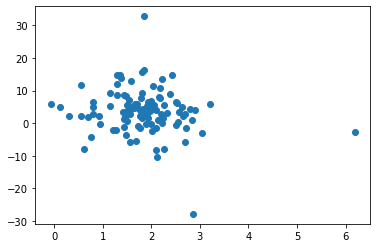

In [262]:
plt.scatter(pred, aggregated_reg_table["future_gdp_per_cap_growth"])

(-30.856814197901453, 35.81370408617056)

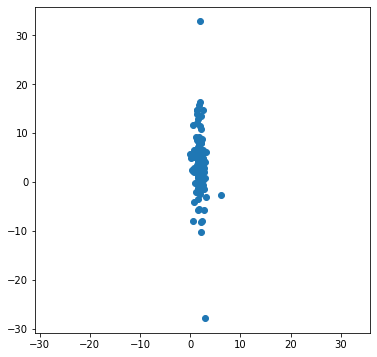

In [264]:
np.corrcoef(pred, aggregated_reg_table["future_gdp_per_cap_growth"])[0,1]**2

0.023212796599265423

# Graph Setup

In [536]:
%%time

years = range(1970,1985)

val_years = [1983]
test_years = [1984]

train_graphs = []
val_graphs = []
test_graphs = []
i = 0

for year in tqdm(years):
    print(str(year), end='\r')
    
    trade = TradeNetwork(year = year)
    trade.prepare_features()
    trade.prepare_network()
    trade.graph_create(node_features = ['prev_gdp_per_cap_growth', 'current_gdp_per_cap_growth',
    'resource_0', 'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5', 'resource_6', 'resource_7',
       'resource_8', 'resource_9'],
        node_labels = 'future_gdp_per_cap_growth')
    
    if(year in val_years):
        val_graphs.append(trade.pyg_graph)
    elif(year in test_years):
        test_graphs.append(trade.pyg_graph)
    else: 
        train_graphs.append(trade.pyg_graph)
        
    trade.features["year"] = year
    
    if(i == 0):
        trade_df = trade.features
    else: 
        trade_df = trade_df.append(trade.features)
        
    i = i+1
    print(trade.node_attributes.size())

torch.Size([99, 12])
torch.Size([99, 12])
torch.Size([108, 12])
torch.Size([108, 12])
torch.Size([108, 12])
torch.Size([108, 12])
torch.Size([110, 12])
torch.Size([112, 12])
torch.Size([114, 12])
torch.Size([119, 12])
torch.Size([119, 12])
torch.Size([121, 12])
torch.Size([130, 12])
torch.Size([133, 12])
torch.Size([136, 12])
CPU times: user 4min 4s, sys: 22 s, total: 4min 26s
Wall time: 4min 30s


In [537]:
test_batch = data.Batch().from_data_list(test_graphs)
val_batch = data.Batch().from_data_list(val_graphs)
train_batch = data.Batch().from_data_list(train_graphs)

In [538]:
trade_df.columns

Index(['index', 'country_code', 'prev_gdp_growth', 'current_gdp_growth',
       'future_gdp_growth', 'prev_gdp', 'current_gdp', 'prev_gdp_per_cap',
       'current_gdp_per_cap', 'future_gdp_per_cap', 'prev_gdp_per_cap_growth',
       'current_gdp_per_cap_growth', 'future_gdp_per_cap_growth', 'resource_0',
       'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5',
       'resource_6', 'resource_7', 'resource_8', 'resource_9', 'node_numbers',
       'year'],
      dtype='object')

In [539]:
result = sm.ols(formula='future_gdp_per_cap_growth~ current_gdp_per_cap_growth+prev_gdp_per_cap_growth', 
             data=trade_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.081
Model:                                   OLS   Adj. R-squared:                  0.080
Method:                        Least Squares   F-statistic:                     75.94
Date:                       Wed, 14 Dec 2022   Prob (F-statistic):           2.48e-32
Time:                               17:05:12   Log-Likelihood:                -5484.0
No. Observations:                       1724   AIC:                         1.097e+04
Df Residuals:                           1721   BIC:                         1.099e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

# PyG Model Definition

In [540]:
from torch_geometric.nn import GATv2Conv, GATConv, GCNConv
import torch.nn.functional as F
import torch_geometric.transforms as T

In [541]:
#test_batch.transform = T.NormalizeFeatures()
#val_batch.transform = T.NormalizeFeatures()
#train_batch.transform = T.NormalizeFeatures()

In [574]:
class GNN(torch.nn.Module):
    def __init__(self, num_features, num_edge_features,
                 hidden_dim = 10, num_heads = 40, out_feats = 10,drop = 0.2):
        super(GNN, self).__init__()
        self.num_features = num_features
        self.num_edge_features = num_edge_features
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.out_feats = out_feats
        self.drop = drop
        
        
        self.conv1 = GCNConv(self.num_features, self.out_feats, add_self_loops = False, bias = False)
        
        #self.conv1 = GATConv(self.num_features, self.out_feats, heads=self.num_heads, 
        #                       dropout=self.drop, edge_dim = self.num_edge_features, 
        #                     bias = False, add_self_loops = True)
        
        self.linear1 = nn.Linear(self.num_features, 1)
        
        #self.linear2= nn.Linear(self.out_feats*self.num_heads + 1,1, bias = True)
        self.linear2= nn.Linear(self.out_feats,1, bias = True)

    def forward(self, x, edge_index, edge_weight):
        #x, edge_index = data.x, data.edge_index
        
        #x = F.dropout(x, p=self.drop, training=self.training)
        x = self.conv1(x, edge_index, edge_weight)
        #x = F.elu(x)
        #x = F.dropout(x, p=self.drop, training=self.training)
        #x = self.conv2(x, edge_index)
        #x2 = self.linear1(x2)
        #self.linear2(torch.cat((x2,x),1))
        return self.linear2(x)
    
    def reset(self):
        self.linear2.reset_parameters()
        self.conv1.reset_parameters()

In [575]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

loss_fn = torch.nn.MSELoss(reduction = "mean")
model = GNN(num_features = train_batch.num_features, 
            num_edge_features = train_batch.num_edge_features).to(device)
#model = GNN(num_features = train_batch.num_features, 
#            num_edge_features = train_batch.num_edge_features).to(device)
model.reset()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_mse = []
valid_mse = []
best_val_mse = np.inf 
best_model = None
i = 0 
model.train()

for epoch in trange(4000):
    model.train()
    optimizer.zero_grad()
    out = model.forward(train_batch.x, train_batch.edge_index, train_batch.edge_attr)
    #print(out)
    loss = loss_fn(out.to(torch.float).flatten(), train_batch.y)
    train_mse.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    #validation
    model.eval()
    out_val = model(val_batch.x, val_batch.edge_index, val_batch.edge_attr)
    current_val_mse = loss_fn(out_val.to(torch.float).flatten(), val_batch.y).item()
    valid_mse.append(current_val_mse)
    
    #print(model.linear1.weight)
    
   # # early stopping 
    if current_val_mse < best_val_mse:
        best_val_mse = current_val_mse
        best_weights = model.state_dict()
        best_iteration = i
    
    i = i+1

100%|███████████████████████████████████████| 4000/4000 [02:31<00:00, 26.43it/s]


In [560]:
best_iteration

239

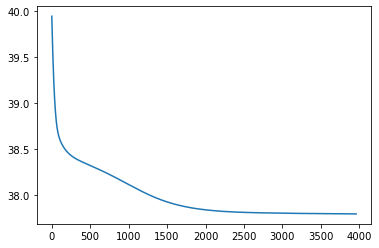

In [576]:
plt.plot(train_mse[40:])

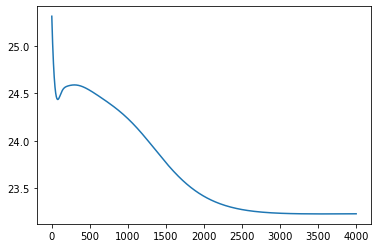

In [577]:
plt.plot(valid_mse)

In [578]:
model.load_state_dict(best_weights)
out_val = model(val_batch.x, val_batch.edge_index, val_batch.edge_attr)
valid_out_list = [item for sublist in out_val.tolist() for item in sublist]
valid_df = trade_df[trade_df.year.isin(val_years)]
valid_df["pred"] = valid_out_list

/tmp/ipykernel_1373438/387021926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["pred"] = valid_out_list


In [579]:
valid_df

,index,country_code,prev_gdp_growth,current_gdp_growth,future_gdp_growth,prev_gdp,current_gdp,prev_gdp_per_cap,current_gdp_per_cap,future_gdp_per_cap,...,resource_3,resource_4,resource_5,resource_6,resource_7,resource_8,resource_9,node_numbers,year,pred
0,2,AGO,0.000000,4.200001,6.000002,-0.344494,-0.316559,619.959903,623.440047,637.715098,...,9.669948,0.000000,0.000519,0.005412,0.007459,0.002400,0.024973,0,1983,0.480781
1,3,AND,1.246461,1.770118,1.784687,-1.235474,-1.267204,9610.020616,8025.207641,7728.906695,...,0.055203,0.003099,0.094196,2.465849,2.272600,1.914061,0.124961,1,1983,-0.063039
2,5,ARE,-6.719316,-4.745821,4.016951,0.359799,0.346322,40025.822624,34843.159626,32309.832713,...,9.244663,0.002089,0.028120,0.349803,0.124311,0.102205,0.038545,2,1983,1.248557
3,6,ARG,-0.735659,4.349093,1.570739,0.555838,0.640285,2927.897357,3553.377509,2659.708242,...,0.080409,0.719742,0.575831,0.959789,0.516924,0.132742,0.047231,3,1983,1.429152
4,7,ATG,-0.084012,5.364016,10.164996,-1.509220,-1.461880,2660.558091,2948.317275,3372.602070,...,0.000000,0.000000,0.330333,1.409294,1.302109,6.096207,0.004043,4,1983,-1.455333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,179,VEN,-2.071006,-3.764817,1.442165,0.483416,0.497463,4228.902648,4108.481006,3555.806233,...,7.977507,0.022214,0.384118,1.012529,0.072326,0.027783,0.116498,128,1983,0.269555
129,180,VUT,1.979883,3.009629,9.574991,-1.628860,-1.607376,943.194390,945.066573,1137.138278,...,0.000000,0.000000,0.000000,0.007115,0.000000,0.040526,0.000000,129,1983,0.897550
130,182,ZAF,-0.383419,-1.846558,5.099152,0.562046,0.614545,2849.180570,3103.983020,2665.386369,...,1.182575,0.022561,0.724303,3.171675,0.185134,0.641042,0.538092,130,1983,1.163298
131,183,ZMB,-2.812783,-1.966689,-0.336835,-0.453336,-0.510946,637.545690,496.197754,408.777920,...,0.020058,0.000733,0.005787,9.282008,0.043878,0.025820,0.008154,131,1983,1.393661


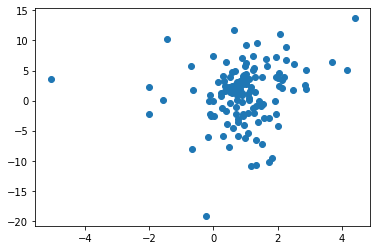

In [580]:
plt.scatter(valid_df["pred"], valid_df["future_gdp_per_cap_growth"])

(-20.82362341641022, 15.33352666269962)

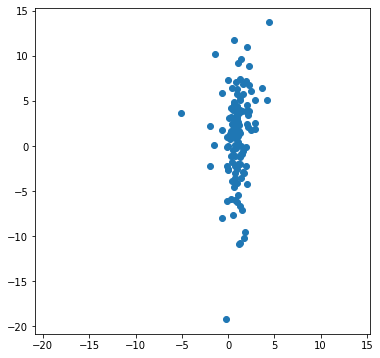

In [581]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(valid_df["pred"], valid_df["future_gdp_per_cap_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

In [582]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ pred +current_gdp_per_cap_growth + prev_gdp_per_cap_growth', 
             data=valid_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.164
Model:                                   OLS   Adj. R-squared:                  0.145
Method:                        Least Squares   F-statistic:                     8.456
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):           3.59e-05
Time:                               15:24:16   Log-Likelihood:                -387.74
No. Observations:                        133   AIC:                             783.5
Df Residuals:                            129   BIC:                             795.0
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [583]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ pred', 
             data=valid_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.031
Model:                                   OLS   Adj. R-squared:                  0.024
Method:                        Least Squares   F-statistic:                     4.207
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):             0.0422
Time:                               15:24:17   Log-Likelihood:                -397.58
No. Observations:                        133   AIC:                             799.2
Df Residuals:                            131   BIC:                             804.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [569]:
#evaluate on test set
#evaluate on test set
model.load_state_dict(best_weights)
out_val = model(test_batch.x, test_batch.edge_index, test_batch.edge_attr)
test_out_list = [item for sublist in out_val.tolist() for item in sublist]
test_df = trade_df[trade_df.year.isin(test_years)]
test_df["pred"] = test_out_list

/tmp/ipykernel_1373438/1946012134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred"] = test_out_list


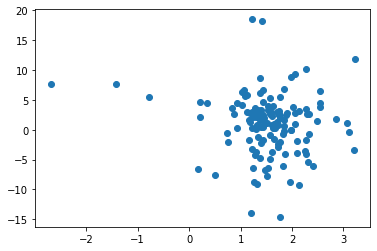

In [570]:
plt.scatter(test_df["pred"], test_df["future_gdp_per_cap_growth"])

(-16.26411981185805, 20.15342023789545)

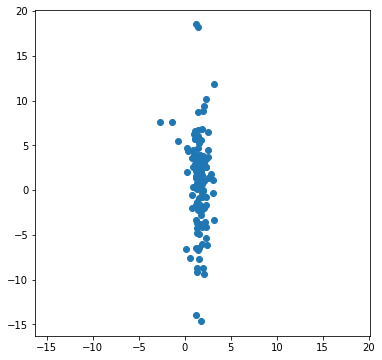

In [571]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_df["pred"], test_df["future_gdp_per_cap_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

In [572]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ pred', 
             data=test_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.012
Model:                                   OLS   Adj. R-squared:                  0.005
Method:                        Least Squares   F-statistic:                     1.623
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):              0.205
Time:                               14:58:09   Log-Likelihood:                -410.46
No. Observations:                        136   AIC:                             824.9
Df Residuals:                            134   BIC:                             830.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [573]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ current_gdp_per_cap_growth+prev_gdp_per_cap_growth +pred', 
             data=test_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.163
Model:                                   OLS   Adj. R-squared:                  0.144
Method:                        Least Squares   F-statistic:                     8.581
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):           3.02e-05
Time:                               14:58:09   Log-Likelihood:                -399.16
No. Observations:                        136   AIC:                             806.3
Df Residuals:                            132   BIC:                             818.0
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

### Hyperparameter Tuning of a Simple Model

In [397]:
learning_rates = [0.0005, 0.0001, 0.001]
attn_drop_rates = [0, 0.1]
feat_drop_rates = [0, 0.1]
num_heads_list = [10, 20, 50, 100]
num_feat_list = [5, 10, 20, 50]
num_epochs_list = [500, 10000]

list_model_params = []

for lr in learning_rates:
    for attn_drop in attn_drop_rates:
        for feat_drop in feat_drop_rates:
            for num_heads in num_heads_list:
                for num_feats in num_feat_list:
                    
                    
                    

IndentationError: expected an indented block (3182354760.py, line 17)

In [ ]:
class NodeRegressor(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, out_feats = 1)
        #self.pooling = AvgPooling()
        #self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        #self.reg_input_dim = reg_input_dim
        #self.dropout = nn.Dropout(0.8)
        #self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        #self.linear_comb = nn.Linear(2,1)
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x = self.pooling(graph, x)
        x = self.MLP(x)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        x = torch.cat((x,out),1)
        #return x, reg_data
        x = self.linear_comb(x)
        #print(x.dtype)
        return x

# Hyperparameter Tuning - Experimenting with Performance

In [ ]:
#create function to make graphs compatible with regression tables
def pred_group_for_graphs(gnn_table, lookbacks):
    """ gnn_table: graph table, as generated by gm.submissions_agg 
        lookbacks: number of lookbacks in gnn_table
        
        In order to merge with dependent variable and to ensure a walk-between equivalently structured regression, 
        need to create "pred_group" column. "pred_group" and "ticker" are two columns that enable joining
        between regression tables and graph tables. 
        
        "ticker" is a column already included
        "pred_group" needds to be created. If we have only one lookback window - "pred_group" = "ind_group"
        otherwise: we build a longer graph which spans all relevant ind_groups (all lookback periods are 
        combined into longer time frame)
        
        function returns gnn_table of submissions and pred_group
        """
    
    
    #if we have a single lookback period - ind_group is equivalent to pred_group
    if(lookbacks == 1):
        gnn_table["pred_group"] = gnn_table["ind_group"]
        return(gnn_table)
    #if we have multiple lookback period - we combine all nodes within all lookback periods
    else:
        #we create long table 
        
        #find all indicator columns
        ind_group_cols = []
        for lookback in range(lookbacks):
            ig =f'ind_group_{lookback}'
            ind_group_cols.append(ig)

        long_gnn_table = pd.DataFrame()
        
        i = 0
        
        #for each indicator group - append rows
        for ind_group_col in ind_group_cols:
            
            if (i == 0):
                gnn_table["pred_group"] = gnn_table[ind_group_col]
                long_gnn_table = gnn_table.drop(columns = ind_group_cols)
            else:
                gnn_table["pred_group"] = gnn_table[ind_group_col]
                long_gnn_table = long_gnn_table.append(gnn_table.drop(columns = ind_group_cols), 
                                                      ignore_index = True)
            i = i+1
        
        long_gnn_table = long_gnn_table.drop_duplicates()
        return(long_gnn_table)
                                                    

# Apply Log Transforms to y variables

In [ ]:
def log_transform(table, y_col = "num_submissions_future"):
    new_col = y_col + "_log"
    table[new_col] = np.log(table[y_col]+1)
    return(table)

In [ ]:
def run_reg_module(X_train, X_val, X_test, y_train, y_val, y_test):
    
    #remove NA - first from y, then from X
    y_train = y_train[~y_train.index.isin(X_train[X_train.isna().any(axis = 1)].index)]
    y_val = y_val[~y_val.index.isin(X_val[X_val.isna().any(axis = 1)].index)]
    y_test = y_test[~y_test.index.isin(X_test[X_test.isna().any(axis = 1)].index)]
    
    X_train = X_train[~X_train.index.isin(X_train[X_train.isna().any(axis = 1)].index)]
    X_val = X_val[~X_val.index.isin(X_val[X_val.isna().any(axis = 1)].index)]
    X_test = X_test[~X_test.index.isin(X_test[X_test.isna().any(axis = 1)].index)]
    
    #combine train, val for full model fitting
    X_train_val = X_train.append(X_val)
    y_train_val = y_train.append(y_val)
    
    #scale
    ss = StandardScaler()
    ss.fit(X_train)
    
    X_train = ss.transform(X_train)
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)
    X_train_val = ss.transform(X_train_val)
    
    # Add constant 
    X_train = sm.add_constant(X_train)
    X_val = sm.add_constant(X_val)
    X_test = sm.add_constant(X_test)
    X_train_val = sm.add_constant(X_train_val)
    
    #run regularized OLS
    alphas = [0.1,1,10,100]
    l1s = np.linspace(0,1,11)
    models = {'model':[],'alpha':[],'l1_wt':[], 'r2':[]}
    for a in alphas:
        for l1 in l1s:
            models['alpha'].append(a)
            models['l1_wt'].append(l1)
            model = sm.OLS(y_train, X_train, missing = "drop").fit_regularized(alpha=a, L1_wt=l1, refit=False)
            models['model'].append(model)
            pred = model.predict(X_val)
            r2 = r2_score(y_val, pred)
            models['r2'].append(r2)
    
    models = pd.DataFrame(models).sort_values('r2', ascending=False).reset_index()
    
    #extract optimal alpha, l1
    alpha_opt = models.iloc[0]["alpha"]
    l1_opt = models.iloc[0]["l1_wt"]
    
    #l1_opt = 0
    
    #retrain optimal model on train, val 
    if(l1_opt == 0): 
        opt_model = sm.OLS(y_train_val, X_train_val).fit()
    else:
        opt_model = sm.OLS(y_train_val, X_train_val, missing = "drop").fit_regularized(alpha=alpha_opt, 
                                                                               L1_wt=l1_opt, refit=False)
    #evaluate performance on test set
    pred = opt_model.predict(X_test)
    r2 = r2_score(y_test, pred)
    
    return r2, opt_model

### Check Graph Table

In [ ]:
def tvt_split(reg_table, graph_table,
    x_cols_to_elim_reg = ['pred_group', 'pred_group_start', 'pred_group_end', "ticker", 
                      'num_submissions_future', 'num_comments_future', 'num_authors_future',
                      'ncf_bin', 'nearest_bday', 'source'],
    y_col = "num_submissions_future", 
    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin'],
    x_cols_graph = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'created_utc'],
    test_frac = 0.2, val_frac = 0.2, rand_seed= 192,
             stratify = True):
    
    """
    reg_table: regression table built by dl.create_regression_table
    graph_table: graph learning table created by gm.submission_agg and pred_group columns created using 
        pred_group_for_graphs function
    x_cols_to_elim_reg - x columns eliminated from regression table
    y_col - y column chosen as dependent variable for regression
    y_cols_to_elim_reg - y columns to be eliminated
    x_cols_graph - x columns selected for graph table (to be normalized as denep)
    test_frac - fraction of data for test set
    val_frac - fraction of data for val set
    
    Function produces train, val, test tables from a regression table; it returns a re-scaled graph table 
    with indicators of whether a node belongs to train, val or test
    
    """
####Create regression tables
    cols = reg_table.columns 
    cols = [col for col in cols if col not in x_cols_to_elim_reg]
    cols = [col for col in cols if col not in y_cols_to_elim_reg]
    
    #create reg train, val, test split
    if(stratify):
        regX_train, regX_val, regX_test, regy_train, regy_val, regy_test = DL.stratify_train_test_split(data = reg_table,                                   
                            x= cols, y=y_col, test_size=test_frac, val_size = val_frac, random_state = rand_seed)
    else: 
        regX_train, regX_val, regX_test, regy_train, regy_val, regy_test = DL.forecasting_split(data = reg_table,                                   
                            x= cols, y=y_col, test_size=test_frac, val_size = val_frac, random_state = rand_seed)
        
####Infrastructure for combining with graph data
    #combine into single dataframe to combine this with graph table on "pred_group" and "ticker" columns
    #create new column tracking which submissions belong to train, val and test
    
    temp_train = regX_train.copy().reset_index()
    temp_train["train_val_test"] = "train"
    temp_val = regX_val.copy().reset_index()
    temp_val["train_val_test"] = "val"
    temp_test = regX_test.copy().reset_index()
    temp_test["train_val_test"] = "test"
    
    combined = temp_train.append(temp_val, ignore_index = True)
    combined = combined.append(temp_test, ignore_index = True)
    
    combined = combined.dropna()
    
    #scaler = StandardScaler()
    #scaler.fit(combined[combined["train_val_test"] == "train"][cols])
    #rescale reg
    #combined[cols] = scaler.transform(combined[cols])
    
    cols_new = [val if val not in x_cols_graph else val+"_reg" for val in cols]
    
    #x_cols_graph.extend(cols)
    
    #print(x_cols_graph)
    
    graph_table = graph_table.merge(combined,
                               on = ["pred_group", "ticker"],
                                suffixes = ("","_reg"))
    
    # train scaler only on train set 
    scaler = StandardScaler()
    scaler.fit(graph_table[graph_table["train_val_test"] == "train"][x_cols_graph])
    #rescale graph
    graph_table[x_cols_graph] = scaler.transform(graph_table[x_cols_graph])
    
    scaler = StandardScaler()
    scaler.fit(graph_table[graph_table["train_val_test"] == "train"].drop_duplicates().copy()[cols_new])
    #rescale graph
    graph_table[cols_new] = scaler.transform(graph_table[cols_new])
    
    #create column for future idenfitication of specific pred_ticker combos
    graph_table["pred_ticker"] = graph_table.apply(lambda row: (row["pred_group"], row["ticker"]), axis = 1)
    
    return(regX_train, regX_val, regX_test, regy_train, regy_val, regy_test, graph_table)

In [ ]:
def graph_create(graph_table, pred_group_select, ticker_select,
                 
                y_col = "num_submissions_future",
                reg_columns = ['total_sub',
       'avg_level_reg', 'max_level_reg', 'total_com_reg', 'max_num_com',
       'max_num_auth', 'avg_num_auth', 'total_auth', 'avg_num_com',
       'overall_posts', 'overall_engagements', 'overall_authors',
       'return_mean', 'return_std', 'vol_mean', 'vol_std',
       'log_return_mean_reg', 'log_return_std_reg', 'return_var', 'vol_var', 'mkt_cap_reg']):
    
    """
    graph_table: graph learning table created by gm.submission_agg and pred_group columns created using 
        pred_group_for_graphs function
    pred_group_select: pred_group identifier
    ticker_select: selected ticker
    -- pred_group,ticker combination regers to unique graph 
    y_col: dependent variable selected to create graph label
    
    Function takes in graph table with specific pred_group, ticker - creates a graph 
    (storing all data from independent variables in a graph structure for learning) and a label - encoding dependt var
    
    graphs can be fed for learning into GNN
    
    """
    
    #filter data to the data we are trying to use
    graph = graph_table[((graph_table["pred_group"] == pred_group_select) & \
                        (graph_table["ticker"] == ticker_select))].copy()
    
    #label is the dependent variable - for each pred_group, ticker combination - label is constant
        #if not - we print a warning
    temp = list(set(graph[y_col]))
    if(len(temp) > 1): print("too many dependent variables for " + ticker_select + str(pred_group_select))
    label = torch.tensor(np.float32(temp[0]))
    
    #extract reg- columns 
    
    
    #create list of all submissions - these are all the nodes in our graph
    nodes = list(set(graph["submission_id"]))
    node_dict = {}
    node_num = []
    i = 0

    node_attributes = []
    node_attributes_no_mkt = []
    node_attributes_only_mkt = []

    #create a dict where we can go between numbers for node and name of node
    #store node attributes here in NxD dimentional array - row number corresponds to node
    for index, row in graph.iterrows():
        
        if(i == 0):
            reg_vars = np.array(row[reg_columns].values, dtype = np.float32)
            #reg_vars = reg_vars.reshape(-1,len(reg_vars))
            #reg_vars = torch.tensor(np.array(reg_vars))
        
        node_dict[i] = row["submission_id"]
        node_num.append(i)
        i = i+1
        node_attributes.append([np.float32(row["num_auth"]), np.float32(row["avg_level"]), 
                                np.float32(row["max_level"]), np.float32(row["total_com"]),
                                np.float32(row["pct_ch"]), np.float32(row["mkt_cap"]),
                                np.float32(row["log_return_mean"]), np.float32(row["log_return_std"]), 
                                np.float32(row["num_authors"]), np.float32(row["num_posts"]),
                                np.float32(row["created_utc"])])
        node_attributes_no_mkt.append([np.float32(row["num_auth"]), np.float32(row["avg_level"]), 
                                np.float32(row["max_level"]), np.float32(row["total_com"]), 
                                np.float32(row["num_authors"]), np.float32(row["num_posts"]),
                                np.float32(row["created_utc"])])
        node_attributes_only_mkt.append([np.float32(row["pct_ch"]), np.float32(row["mkt_cap"]),
                                np.float32(row["log_return_mean"]), np.float32(row["log_return_std"])])

    #create complete graph from our numerically stored nodes
    edges = list(combinations(node_num,2))
    #print(edges)

    #add self-loops
    self_loops = [(x,x) for x in node_num]
    edges.extend(self_loops)

    adjacency = skn.utils.edgelist2adjacency(edges, undirected=True)

    g = dgl.from_scipy(adjacency)
    g.ndata["attributes"] = torch.tensor(np.array(node_attributes))
    g.ndata["attributes_no_mkt"] = torch.tensor(np.array(node_attributes_no_mkt))
    g.ndata["attributes_only_mkt"] = torch.tensor(np.array(node_attributes_only_mkt))
    
    #reg_vars = torch.from_numpy(reg_vars.reshape(-1,len(reg_vars)))
    
    return(g,label, reg_vars)

def table_to_graphs(graph_table, y_col_select = "num_submissions_future"):

    pred_ticker_combos = list(set(graph_table["pred_ticker"]))
    
    dgl_graphs = []
    
    for pred_ticker_combo in pred_ticker_combos:
        g, label, reg_vars = graph_create(graph_table, 
                                pred_group_select = pred_ticker_combo[0], 
                                ticker_select = pred_ticker_combo[1],
                               y_col = y_col_select,)
        dgl_graphs.append((g,label, reg_vars, pred_ticker_combo))
    
    return(dgl_graphs)

In [ ]:
def tvt_split_graphs(dataset, graphs_table):
    train = list(set(graphs_table[graphs_table["train_val_test"] == "train"]["pred_ticker"]))
    val = list(set(graphs_table[graphs_table["train_val_test"] == "val"]["pred_ticker"]))
    test = list(set(graphs_table[graphs_table["train_val_test"] == "test"]["pred_ticker"]))
  
    train_set = [tup for tup in dataset if tup[3] in train]
    train_graphs = [tup[0] for tup in train_set]
    train_data = [tup[2] for tup in train_set]
    train_labels = [tup[1] for tup in train_set]
    
    val_set = [tup for tup in dataset if tup[3] in val]
    val_graphs = [tup[0] for tup in val_set]
    val_data = [tup[2] for tup in val_set]
    val_labels = [tup[1] for tup in val_set]
    
    test_set = [tup for tup in dataset if tup[3] in test]
    test_graphs = [tup[0] for tup in test_set]
    test_data = [tup[2] for tup in test_set]
    test_labels = [tup[1] for tup in test_set]
    
    dataset_a = list(zip(train_graphs, train_data, train_labels, train))
    dataset_b = list(zip(val_graphs, val_data, val_labels, val))
    dataset_c = list(zip(test_graphs, test_data, test_labels, test))
    
    return dataset_a, dataset_b, dataset_c

In [ ]:
#set up data loader for 
def collate(samples):
    """Used to create DGL dataloaders."""
    graphs, reg_data, labels, tvt = map(list, zip(*samples)) # converts ((g1, l1), (g2, l2)...) to (g1, g2,...), (l1, l2,...) 
    #print(reg_data)
    batched_graph = dgl.batch(graphs)
    #print(reg_data)
    reg_data = np.array(reg_data)
    reg_data = reg_data.reshape(-1,len(reg_data[0]))
    reg_data = torch.from_numpy(reg_data)
    #print(reg_data)
    
    return batched_graph, reg_data, torch.tensor(labels)

# Different seed comparison

In [ ]:
# change number of output heads for final layer
class GraphRegressor2(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor2, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, hidden_dim, num_heads_out, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.pooling = AvgPooling()
        self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        self.reg_input_dim = reg_input_dim
        self.dropout = nn.Dropout(0.8)
        self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        self.linear_comb1 = nn.Linear(2,4)
        self.linear_comb2 = nn.Linear(4,1)
        self.positive = nn.Softplus()
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x = self.pooling(graph, x)
        x = self.MLP(x)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        x = torch.cat((x,out),1)
        #return x, reg_data
        x = torch.relu(self.linear_comb1(x))
        x = self.linear_comb2(x)
        x = self.positive(x)
        #print(x.dtype)
        return x

In [ ]:
def run_gnn_module2(train, val, test, 
                   gnn_epochs = 50, batches = 200, 
                   plot = False, attribute_select = "attributes"):

    train_loader = DataLoader(train, batch_size=batches, shuffle=True, collate_fn=collate, drop_last = True)
    valid_loader = DataLoader(val, batch_size=batches, collate_fn=collate, drop_last = True)
    test_loader = DataLoader(test, batch_size=batches, collate_fn=collate, drop_last = True)
    
    #set up initial GNN module 
    #find initial input dimension from attirbutes selected
    gnn_input_dim = len(train[0][0].ndata[attribute_select].detach().numpy()[0])
    reg_input_dim = len(train[0][1])
    model = GraphRegressor2(input_dim=gnn_input_dim, attribute_type = attribute_select, 
                           reg_input_dim = reg_input_dim)
    
    loss_fn = torch.nn.MSELoss(reduction='none')
    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001) #perhaps worth playing with 

    #optimizer specifying different learning rates: https://discuss.pytorch.org/t/how-to-specify-only-single-module-in-the-per-parameter-options/91008/2
    #my_list = ['linear_reg.weight', 'linear_reg.bias']
    #optimizer = torch.optim.Adam([{'params': [p for n, p in model.named_parameters() if n not in my_list]},
    #            {'params': [p for n, p in model.named_parameters() if n in my_list], 'lr': 0.001}], 
    #                              lr=0.0001, weight_decay = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    
    #set up model and parameters tracking performance
    best_val_mse = np.inf 
    best_model = None
    training_logs = []
    num_epochs = gnn_epochs
    
    #train NN model
    for epoch in trange(num_epochs):
    
        # training step
        model.train()
        train_mse = []
        
        for i, (graphs, reg_data, labels) in enumerate(train_loader):

            #print(graphs)
            #squeeze operation 
            predictions = model(graphs, reg_data).squeeze()
            #print(predictions)
            #print(predictions)
            loss = loss_fn(predictions, labels)#+l1_regularizer(model, )
            train_mse.append(loss.detach().numpy())
            loss = loss.mean()
            optimizer.zero_grad()
            #loss.backward generates type problem: possibly linked to: https://discuss.pytorch.org/t/strange-error-from-loss-backward/62344
            #loss = torch.tensor(loss, dtype = torch.float, requires_grad = True)
            loss.backward()
            optimizer.step()
            #s = model.MLP1.weight.data.abs()
            #print(s)
            #lossl1 = l1_regularizer(model,)
            #print(lossl1)
        #print(model.linear_reg.weight.data.abs().sum())
        train_mse = np.mean(np.concatenate(train_mse))
        #print(train_mse)

        # validation step
        model.eval()
        valid_mse = []
        for i, (graphs, reg_data,labels) in enumerate(valid_loader):
            predictions = model(graphs,reg_data).squeeze()
            #print(reg_data)
            loss = loss_fn(predictions, labels)
            valid_mse.append(loss.detach().numpy())
        valid_mse = np.mean(np.concatenate(valid_mse))
        
        #print(valid_mse)

        # early stopping 
        if valid_mse < best_val_mse:
            best_val_mse = valid_mse
            best_weights = model.state_dict()

        training_logs.append((train_mse, valid_mse))

    training_logs = np.array(training_logs)
    
    #evaluate model performance
    model.load_state_dict(best_weights)
    store_test_mse  = []
    store_test_l1  = []
    store_labels = []
    store_predictions = []
    
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_mse = nn.MSELoss(reduction='none')
    
    for i, (graphs, reg_data, labels) in enumerate(test_loader):
        predictions = model(graphs, reg_data).squeeze()
        #evaluate l1 loss
        loss_l1 = loss_fn_l1(predictions, labels)
        store_test_l1.append(loss.detach().numpy())
        #evaluate mse loss
        loss_mse = loss_fn_mse(predictions, labels)
        store_test_mse.append(loss.detach().numpy())
        #store labels
        store_labels.append(labels.detach().numpy())
        store_predictions.append(predictions.detach().numpy())
    
    #store evaluation
    r2 = r2_score(np.concatenate(store_labels), 
                  np.concatenate(store_predictions))
    test_mse = np.mean(np.concatenate(store_test_mse))
    test_l1 = np.mean(np.concatenate(store_test_l1))
    
    #print(model.linear_comb.weight.data)
    
    if (plot == True):
        #plot how model performance evovles over time 
        fig, ax = plt.subplots()
        skip = 5
        ax.plot(range(skip, num_epochs), training_logs[skip:,0], label='train')
        ax.plot(range(skip, num_epochs), training_logs[skip:,1], label='valid')
        ax.plot([skip, num_epochs], [test_l1, test_l1], label='test', linestyle='dashed')
        ax.legend()
        
    
    return(r2, test_mse, test_l1)

In [ ]:
# change number of output heads for final layer
class GraphRegressor(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, hidden_dim, num_heads_out, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.pooling = AvgPooling()
        self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        self.reg_input_dim = reg_input_dim
        self.dropout = nn.Dropout(0.8)
        self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        self.linear_comb = nn.Linear(2,1)
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x = self.pooling(graph, x)
        x = self.MLP(x)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        x = torch.cat((x,out),1)
        #return x, reg_data
        x = self.linear_comb(x)
        #print(x.dtype)
        return x

In [ ]:
def run_gnn_module(train, val, test, 
                   gnn_epochs = 50, batches = 200, 
                   plot = False, attribute_select = "attributes"):

    train_loader = DataLoader(train, batch_size=batches, shuffle=True, collate_fn=collate, drop_last = True)
    valid_loader = DataLoader(val, batch_size=batches, collate_fn=collate, drop_last = True)
    test_loader = DataLoader(test, batch_size=batches, collate_fn=collate, drop_last = True)
    
    #set up initial GNN module 
    #find initial input dimension from attirbutes selected
    gnn_input_dim = len(train[0][0].ndata[attribute_select].detach().numpy()[0])
    reg_input_dim = len(train[0][1])
    model = GraphRegressor(input_dim=gnn_input_dim, attribute_type = attribute_select, 
                           reg_input_dim = reg_input_dim)
    
    loss_fn = torch.nn.MSELoss(reduction='none')
    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001) #perhaps worth playing with 

    #optimizer specifying different learning rates: https://discuss.pytorch.org/t/how-to-specify-only-single-module-in-the-per-parameter-options/91008/2
    #my_list = ['linear_reg.weight', 'linear_reg.bias']
    #optimizer = torch.optim.Adam([{'params': [p for n, p in model.named_parameters() if n not in my_list]},
    #            {'params': [p for n, p in model.named_parameters() if n in my_list], 'lr': 0.001}], 
    #                              lr=0.0001, weight_decay = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    
    #set up model and parameters tracking performance
    best_val_mse = np.inf 
    best_model = None
    training_logs = []
    num_epochs = gnn_epochs
    
    #train NN model
    for epoch in trange(num_epochs):
    
        # training step
        model.train()
        train_mse = []
        for i, (graphs, reg_data, labels) in enumerate(train_loader):

            #print(graphs)
            #squeeze operation 
            predictions = model(graphs, reg_data).squeeze()
            print(predictions)
            #print(predictions)
            loss = loss_fn(predictions, labels)#+l1_regularizer(model, )
            train_mse.append(loss.detach().numpy())
            loss = loss.mean()
            optimizer.zero_grad()
            #loss.backward generates type problem: possibly linked to: https://discuss.pytorch.org/t/strange-error-from-loss-backward/62344
            #loss = torch.tensor(loss, dtype = torch.float, requires_grad = True)
            loss.backward()
            optimizer.step()
            #s = model.MLP1.weight.data.abs()
            #print(s)
            #lossl1 = l1_regularizer(model,)
            #print(lossl1)
        #print(model.linear_reg.weight.data.abs().sum())
        train_mse = np.mean(np.concatenate(train_mse))
        print(train_mse)

        # validation step
        model.eval()
        valid_mse = []
        for i, (graphs, reg_data,labels) in enumerate(valid_loader):
            predictions = model(graphs,reg_data).squeeze()
            #print(reg_data)
            loss = loss_fn(predictions, labels)
            valid_mse.append(loss.detach().numpy())
        valid_mse = np.mean(np.concatenate(valid_mse))
        
        #print(valid_mse)

        # early stopping 
        if valid_mse < best_val_mse:
            best_val_mse = valid_mse
            best_weights = model.state_dict()

        training_logs.append((train_mse, valid_mse))

    training_logs = np.array(training_logs)
    
    #evaluate model performance
    model.load_state_dict(best_weights)
    store_test_mse  = []
    store_test_l1  = []
    store_labels = []
    store_predictions = []
    
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_mse = nn.MSELoss(reduction='none')
    
    for i, (graphs, reg_data, labels) in enumerate(test_loader):
        predictions = model(graphs, reg_data).squeeze()
        #evaluate l1 loss
        loss_l1 = loss_fn_l1(predictions, labels)
        store_test_l1.append(loss.detach().numpy())
        #evaluate mse loss
        loss_mse = loss_fn_mse(predictions, labels)
        store_test_mse.append(loss.detach().numpy())
        #store labels
        store_labels.append(labels.detach().numpy())
        store_predictions.append(predictions.detach().numpy())
    
    #store evaluation
    r2 = r2_score(np.concatenate(store_labels), 
                  np.concatenate(store_predictions))
    test_mse = np.mean(np.concatenate(store_test_mse))
    test_l1 = np.mean(np.concatenate(store_test_l1))
    
    #print(model.linear_comb.weight.data)
    
    if (plot == True):
        #plot how model performance evovles over time 
        fig, ax = plt.subplots()
        skip = 5
        ax.plot(range(skip, num_epochs), training_logs[skip:,0], label='train')
        ax.plot(range(skip, num_epochs), training_logs[skip:,1], label='valid')
        ax.plot([skip, num_epochs], [test_l1, test_l1], label='test', linestyle='dashed')
        ax.legend()
        
    
    return(r2, test_mse, test_l1)

In [ ]:
# Try with different lookback and lookforward

date_combos = [('40D', '30D'), ('60D', '30D'), ('20D', '10D')]


for comb in date_combos:
    lookback = comb[0]
    lookforward = comb[1]
    
    #########create tables
    reg_table, graph_table = create_graph_from_spec(markets, period = lookback, 
                               lookback = 1, lookforward = lookforward, inspect = False)
    
    #########find pred group
    #recalculate graphs with pred groups
    graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
    graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
                 on = ["pred_group", "ticker"]) 

    #check no strange rows have been generated - implying a bad match between reg and graph table
    if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
    if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

    #convert created date to utc timestamp
    graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())
    
    #########log tranform dep variable
    graph_new = log_transform(graph_new)
    reg_table = log_transform(reg_table)

    graph_new = log_transform(graph_new, y_col = "num_comments_future")
    reg_table = log_transform(reg_table, y_col = "num_comments_future")
    
    ########TVT split
    
    regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                        graph_new,
                                                                                         rand_seed = 10,
                                                                                                y_col = "num_comments_future_log",
                        y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                             'num_submissions_future_log', 'num_comments_future_log'])

    graph_table = graph_table.dropna()
    
    #######Run penalized regression
    r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)
    
    print("\nReg r2 = " + str(r2_reg))
    
    #######prepare and run GNN
    
    dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")
    
    graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                     graphs_table = graph_table)
    
    r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                       plot= True, gnn_epochs = 70)
    
    print("GNN non fully connected final layer r2 = " + str(r2_gnn1))

In [ ]:
seeds = [15, 20, 25, 30]

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

for seed in seeds:
    
    ########TVT split
    
    regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                        graph_new,
                                                                                         rand_seed = seed,
                                                                                                y_col = "num_comments_future_log",
                        y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                             'num_submissions_future_log', 'num_comments_future_log'])

    graph_table = graph_table.dropna()
    
    #######Run penalized regression
    r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)
    
    print("\nReg r2 = " + str(r2_reg))
    
    #######prepare and run GNN
    
    dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")
    
    graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                     graphs_table = graph_table)
    
    r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                       plot= True, gnn_epochs = 70)
    r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                       plot= True, gnn_epochs = 70)
    
    print("GNN non fully connected final layer r2 = " + str(r2_gnn1))
    print(str(seed))
    
    print("Reg r2 = " + str(r2_reg))
    
    print("GNN non fully connected final layer r2 = " + str(r2_gnn1))
    

    print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")
    
regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)

graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

# Additional GNN architecture experiments

In [ ]:
# change number of output heads for final layer
class GraphRegressor(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, hidden_dim, num_heads_out, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.pooling1 = AvgPooling()
        self.pooling2 = MaxPooling()
        self.pooling3 = SumPooling()
        self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        self.reg_input_dim = reg_input_dim
        self.dropout = nn.Dropout(0.8)
        self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        self.linear_comb = nn.Linear(4,1)
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x1 = self.pooling1(graph, x)
        x1 = self.MLP(x1)
        x2 = self.pooling2(graph, x)
        x2 = self.MLP(x2)
        x3 = self.pooling3(graph, x)
        x3 = self.MLP(x3)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        #x_fin = torch.cat((x3,out),1)
        x_fin = torch.cat((x1,x2,x3,out),1)
        #print(x3)
        #print(x2)
        #print(x3)
        #return x, reg_data
        x_fin = self.linear_comb(x_fin)
        #print(x.dtype)
        return x_fin

In [ ]:
def run_gnn_module(train, val, test, 
                   gnn_epochs = 50, batches = 200, 
                   plot = False, attribute_select = "attributes"):

    train_loader = DataLoader(train, batch_size=batches, shuffle=True, collate_fn=collate, drop_last = True)
    valid_loader = DataLoader(val, batch_size=batches, collate_fn=collate, drop_last = True)
    test_loader = DataLoader(test, batch_size=batches, collate_fn=collate, drop_last = True)
    
    #set up initial GNN module 
    #find initial input dimension from attirbutes selected
    gnn_input_dim = len(train[0][0].ndata[attribute_select].detach().numpy()[0])
    reg_input_dim = len(train[0][1])
    model = GraphRegressor(input_dim=gnn_input_dim, attribute_type = attribute_select, 
                           reg_input_dim = reg_input_dim)
    
    loss_fn = torch.nn.MSELoss(reduction='none')
    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001) #perhaps worth playing with 

    #optimizer specifying different learning rates: https://discuss.pytorch.org/t/how-to-specify-only-single-module-in-the-per-parameter-options/91008/2
    #my_list = ['linear_reg.weight', 'linear_reg.bias']
    #optimizer = torch.optim.Adam([{'params': [p for n, p in model.named_parameters() if n not in my_list]},
    #            {'params': [p for n, p in model.named_parameters() if n in my_list], 'lr': 0.001}], 
    #                              lr=0.0001, weight_decay = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

    
    #set up model and parameters tracking performance
    best_val_mse = np.inf 
    best_model = None
    training_logs = []
    num_epochs = gnn_epochs
    
    #train NN model
    for epoch in trange(num_epochs):
    
        # training step
        model.train()
        train_mse = []
        for i, (graphs, reg_data, labels) in enumerate(train_loader):

            #print(graphs)
            #squeeze operation 
            predictions = model(graphs, reg_data).squeeze()
            #print(predictions)
            #print(predictions)
            loss = loss_fn(predictions, labels)#+l1_regularizer(model, )
            train_mse.append(loss.detach().numpy())
            loss = loss.mean()
            optimizer.zero_grad()
            #loss.backward generates type problem: possibly linked to: https://discuss.pytorch.org/t/strange-error-from-loss-backward/62344
            #loss = torch.tensor(loss, dtype = torch.float, requires_grad = True)
            loss.backward()
            optimizer.step()
            #s = model.MLP1.weight.data.abs()
            #print(s)
            #lossl1 = l1_regularizer(model,)
            #print(lossl1)
        #print(model.linear_reg.weight.data.abs().sum())
        train_mse = np.mean(np.concatenate(train_mse))
        #print(train_mse)

        # validation step
        model.eval()
        valid_mse = []
        for i, (graphs, reg_data,labels) in enumerate(valid_loader):
            predictions = model(graphs,reg_data).squeeze()
            #print(reg_data)
            loss = loss_fn(predictions, labels)
            valid_mse.append(loss.detach().numpy())
        valid_mse = np.mean(np.concatenate(valid_mse))
        
        #print(valid_mse)

        # early stopping 
        if valid_mse < best_val_mse:
            best_val_mse = valid_mse
            best_weights = model.state_dict()

        training_logs.append((train_mse, valid_mse))

    training_logs = np.array(training_logs)
    
    #evaluate model performance
    model.load_state_dict(best_weights)
    store_test_mse  = []
    store_test_l1  = []
    store_labels = []
    store_predictions = []
    
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_mse = nn.MSELoss(reduction='none')
    
    for i, (graphs, reg_data, labels) in enumerate(test_loader):
        predictions = model(graphs, reg_data).squeeze()
        #evaluate l1 loss
        loss_l1 = loss_fn_l1(predictions, labels)
        store_test_l1.append(loss.detach().numpy())
        #evaluate mse loss
        loss_mse = loss_fn_mse(predictions, labels)
        store_test_mse.append(loss.detach().numpy())
        #store labels
        store_labels.append(labels.detach().numpy())
        store_predictions.append(predictions.detach().numpy())
    
    #store evaluation
    r2 = r2_score(np.concatenate(store_labels), 
                  np.concatenate(store_predictions))
    test_mse = np.mean(np.concatenate(store_test_mse))
    test_l1 = np.mean(np.concatenate(store_test_l1))
    
    #print(model.linear_comb.weight.data)
    
    if (plot == True):
        #plot how model performance evovles over time 
        fig, ax = plt.subplots()
        skip = 5
        ax.plot(range(skip, num_epochs), training_logs[skip:,0], label='train')
        ax.plot(range(skip, num_epochs), training_logs[skip:,1], label='valid')
        ax.plot([skip, num_epochs], [test_l1, test_l1], label='test', linestyle='dashed')
        ax.legend()
        
    
    return(r2, test_mse, test_l1)

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")
    
regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)

graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
#r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
#                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


#print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

In [ ]:
r2_gnn1

# Experiment with data truncation

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

In [ ]:
#########truncate data for at least 5 submissions in prior periods
reg_table = reg_table[(reg_table["total_sub"] > 5)].copy()
graph_new= graph_new.merge(reg_table[["pred_group", "ticker"]],
                                    on = ["pred_group", "ticker"],
                                    how = "right").copy()

In [ ]:
#filter over 5 ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
#filter over 10 ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = True)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

# Log dependent as well as independent variables 

In [ ]:
def log_transform2(table, col):
    table[col] = np.log(table[col]+1)
    return(table)

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

In [ ]:
reg_table = reg_table[(reg_table["total_sub"] > 5)].copy()
graph_new= graph_new.merge(reg_table[["pred_group", "ticker"]],
                                    on = ["pred_group", "ticker"],
                                    how = "right").copy()

In [ ]:
x_cols_reg_transform = ['total_sub', 'total_com', 'max_num_com',
       'max_num_auth', 'overall_posts', 'overall_engagements', 'overall_authors',
       'mkt_cap', 'vol_mean', 'vol_std']

x_cols_graph_transform = ['total_com', 'mkt_cap', 'num_authors','num_posts']

for col in x_cols_reg_transform:
    reg_table = log_transform2(reg_table, col = col)
    
for col in x_cols_graph_transform:
    graph_new = log_transform2(graph_new, col = col)

In [ ]:
#filter over 5 ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
reg_table = reg_table.dropna()

In [ ]:
graph_new = graph_new.dropna()

In [ ]:
#no filter to number of ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
#r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
reg_table

# Ingest author features

In [ ]:
from dataprocessor import GraphMaker as GM

dl = GM(load_data=False)

subs = dl.load_data('submissions')
coms = dl.load_data('comments')
markets = dl.load_data('market_data')
act = dl.load_data('activity')

markets = dl.create_market_variables(markets, inplace=False, window=30, min_periods=10)
subs, coms, act = dl.apply_filters(subs, coms, act, inplace=False, lookback_freq='60D',lookforward_freq='30D')

In [ ]:
reg_table = dl.create_regression_table(subs, coms, act, markets)
graph_table = dl.submission_agg(subs, coms, markets, act, get_sub_age=True)

In [ ]:
graph_table.columns

In [ ]:
#join sub writer specific columns to graph table
author_columns = ['sub_count_auth_all',
       'sub_score_auth_all', 'sub_replies_auth_all', 'com_count_auth_all',
       'com_score_auth_all', 'com_replies_auth_all', 'age_auth_all',
       'sub_count_auth_ticker', 'sub_score_auth_ticker',
       'sub_replies_auth_ticker', 'com_count_auth_ticker',
       'com_score_auth_ticker', 'com_replies_auth_ticker', 'deleted_auth', 
                 "id"]
graph_table = pd.merge(graph_table, subs[author_columns],
                      left_on = "submission_id",
                      right_on = "id",
                      how = "left")
graph_table = graph_table.drop(columns = ["id"])

In [ ]:
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

In [ ]:
reg_table = reg_table[(reg_table["total_sub"] > 5)].copy()
graph_new= graph_new.merge(reg_table[["pred_group", "ticker"]],
                                    on = ["pred_group", "ticker"],
                                    how = "right").copy()

In [ ]:
#log transform certain independent variables 
x_cols_reg_transform = ['total_sub', 'total_com', 'max_num_com',
       'max_num_auth', 'avg_num_auth', 'total_auth', 'overall_posts', 'overall_engagements', 'overall_authors',
        'overall_posts',
       'mkt_cap', 'vol_mean', 'vol_std',
        'avg_sub_count_auth_all',
       'max_sub_count_auth_all',
       'max_sub_score_auth_all', 'avg_sub_replies_auth_all',
       'max_sub_replies_auth_all', 'avg_com_count_auth_all',
       'max_com_count_auth_all',
       'max_com_score_auth_all', 'avg_com_replies_auth_all',
       'max_com_replies_auth_all', 'avg_age_auth_all', 'max_age_auth_all',
       'avg_sub_count_auth_ticker', 'max_sub_count_auth_ticker', 'max_sub_score_auth_ticker',
       'avg_sub_replies_auth_ticker', 'max_sub_replies_auth_ticker',
       'avg_com_count_auth_ticker', 'max_com_count_auth_ticker', 'max_com_score_auth_ticker',
       'avg_com_replies_auth_ticker', 'max_com_replies_auth_ticker',
       'count_deleted_auth', 'avg_num_com']

x_cols_graph_transform = ['total_com', 'mkt_cap', 'num_authors','num_posts',
                         'sub_count_auth_all', 
       'sub_replies_auth_all', 'com_count_auth_all', 
       'com_replies_auth_all', 'age_auth_all', 'sub_count_auth_ticker', 'sub_replies_auth_ticker',
       'com_count_auth_ticker', 
       'com_replies_auth_ticker']

for col in x_cols_reg_transform:
    reg_table = log_transform2(reg_table, col = col)
    
for col in x_cols_graph_transform:
    graph_new = log_transform2(graph_new, col = col)

In [ ]:
regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    x_cols_graph = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'num_engagements',
           'sub_age', 'sub_count_auth_all', 'sub_score_auth_all', 'deleted_auth'],
                    stratify = False)

In [ ]:
                reg_columns = ['total_sub',
 'avg_level_reg',
 'max_level_reg',
 'total_com_reg',
 'max_num_com',
 'max_num_auth',
 'avg_num_auth',
 'total_auth',
 'avg_sub_count_auth_all_reg',
 'max_sub_count_auth_all_reg',
 'avg_sub_replies_auth_all_reg',
 'max_sub_replies_auth_all_reg',
 'avg_com_count_auth_all_reg',
 'max_com_count_auth_all_reg',
 'avg_com_replies_auth_all_reg',
 'max_com_replies_auth_all_reg',
 'avg_age_auth_all_reg',
 'max_age_auth_all_reg',
 'avg_sub_count_auth_ticker_reg',
 'max_sub_count_auth_ticker_reg',
 'avg_sub_replies_auth_ticker_reg',
 'max_sub_replies_auth_ticker_reg',
 'avg_com_count_auth_ticker_reg',
 'max_com_count_auth_ticker_reg',
 'avg_com_replies_auth_ticker_reg',
 'max_com_replies_auth_ticker_reg',
 'count_deleted_auth_reg',
 'avg_num_com',
 'overall_posts',
 'overall_engagements',
 'overall_authors',
 'return_mean',
 'return_std',
 'vol_mean',
 'vol_std',
 'log_return_mean_reg',
 'log_return_std_reg',
 'return_var',
 'vol_var',
 'mkt_cap_reg']

In [ ]:
x_cols = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'num_engagements',
           'sub_age', 'sub_count_auth_all',
       'sub_replies_auth_all', 'com_count_auth_all',
       'com_replies_auth_all', 'age_auth_all', 'sub_count_auth_ticker', 'sub_replies_auth_ticker',
       'com_count_auth_ticker',
       'com_replies_auth_ticker', 'deleted_auth']

In [ ]:
def graph_create(graph_table, pred_group_select, ticker_select,
                 
                y_col = "num_submissions_future",
                reg_columns = ['total_sub',
 'avg_level_reg',
 'max_level_reg',
 'total_com_reg',
 'max_num_com',
 'max_num_auth',
 'avg_num_auth',
 'total_auth',
 'avg_num_com',
 'overall_posts',
 'overall_engagements',
 'overall_authors',
 'return_mean',
 'return_std',
 'vol_mean',
 'vol_std',
 'log_return_mean_reg',
 'log_return_std_reg',
 'return_var',
 'vol_var',
 'mkt_cap_reg'],
                x_cols = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'num_engagements',
           'sub_age', 'deleted_auth']):
    
    """
    graph_table: graph learning table created by gm.submission_agg and pred_group columns created using 
        pred_group_for_graphs function
    pred_group_select: pred_group identifier
    ticker_select: selected ticker
    -- pred_group,ticker combination regers to unique graph 
    y_col: dependent variable selected to create graph label
    
    Function takes in graph table with specific pred_group, ticker - creates a graph 
    (storing all data from independent variables in a graph structure for learning) and a label - encoding dependt var
    
    graphs can be fed for learning into GNN
    
    """
    
    #filter data to the data we are trying to use
    graph = graph_table[((graph_table["pred_group"] == pred_group_select) & \
                        (graph_table["ticker"] == ticker_select))].copy()
    
    #label is the dependent variable - for each pred_group, ticker combination - label is constant
        #if not - we print a warning
    temp = list(set(graph[y_col]))
    if(len(temp) > 1): print("too many dependent variables for " + ticker_select + str(pred_group_select))
    label = torch.tensor(np.float32(temp[0]))
    
    #extract reg- columns 
    
    
    #create list of all submissions - these are all the nodes in our graph
    nodes = list(set(graph["submission_id"]))
    node_dict = {}
    node_num = []
    i = 0

    node_attributes = []

    #create a dict where we can go between numbers for node and name of node
    #store node attributes here in NxD dimentional array - row number corresponds to node
    for index, row in graph.iterrows():
        
        if(i == 0):
            reg_vars = np.array(row[reg_columns].values, dtype = np.float32)
            #reg_vars = reg_vars.reshape(-1,len(reg_vars))
            #reg_vars = torch.tensor(np.array(reg_vars))
        
        node_dict[i] = row["submission_id"]
        node_num.append(i)
        i = i+1
        node_attributes.append(np.array(list(row[x_cols].values)).astype(np.float32))

    #create complete graph from our numerically stored nodes
    edges = list(combinations(node_num,2))
    #print(edges)

    #add self-loops
    self_loops = [(x,x) for x in node_num]
    edges.extend(self_loops)

    adjacency = skn.utils.edgelist2adjacency(edges, undirected=True)

    g = dgl.from_scipy(adjacency)
    g.ndata["attributes"] = torch.tensor(np.array(node_attributes))
    
    return(g,label, reg_vars)

def table_to_graphs(graph_table, y_col_select = "num_submissions_future"):

    pred_ticker_combos = list(set(graph_table["pred_ticker"]))
    
    dgl_graphs = []
    
    for pred_ticker_combo in pred_ticker_combos:
        g, label, reg_vars = graph_create(graph_table, 
                                pred_group_select = pred_ticker_combo[0], 
                                ticker_select = pred_ticker_combo[1],
                               y_col = y_col_select,)
        dgl_graphs.append((g,label, reg_vars, pred_ticker_combo))
    
    return(dgl_graphs)

In [ ]:
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

print(r2_reg)
#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

In [ ]:
opt_model.params

In [ ]:
dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

In [ ]:
r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 10)

In [ ]:
graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 120)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 120)


print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))